In [1]:
import torch
import torch.nn.functional as F
import numpy as np

from torch.utils.data import Dataset, DataLoader 
from tqdm import tqdm

from dataloader import *

# Visualization
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

# Setting random seed for consistent behavior
import random
train_seed = 72 - 3
random.seed(train_seed)
torch.manual_seed(train_seed)
torch.cuda.manual_seed(train_seed)
torch.backends.cudnn.deterministic = True
random.seed(train_seed)
np.random.seed(train_seed)

In [2]:
torch.autograd.set_detect_anomaly(True)

n_nodes = 8

#batch_size = 16        # Note: in og CML trajectory length == batch_size; in POCML this should be decoupled
state_dim = 500
random_feature_dim = 5000
epochs = 6
n_obs = 8

trajectory_length = 6  # numer of node visits in a trajectory
num_desired_trajectories= 50

# choose env from "random", "small world" or "dead ends"
# TODO devouple batch_size from trajectory length for GraphEnv
env = GraphEnv(size=n_nodes, n_items=n_obs, env='regular', action_type = "regular", batch_size=trajectory_length, num_desired_trajectories=num_desired_trajectories, unique = True)

dataset = RandomWalkDataset(env.adj_matrix, trajectory_length, num_desired_trajectories, n_obs, env.items)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

[(0, 1), (0, 3), (0, 5), (1, 3), (1, 4), (1, 7), (2, 3), (2, 4), (2, 6), (3, 1), (3, 2), (3, 5), (4, 1), (4, 2), (4, 5), (5, 0), (5, 1), (5, 2), (6, 2), (6, 3), (6, 7), (7, 2), (7, 4), (7, 5)] {(0, 1): 0, (0, 3): 1, (0, 5): 2, (1, 3): 0, (1, 4): 1, (1, 7): 2, (2, 3): 2, (2, 4): 1, (2, 6): 0, (3, 1): 0, (3, 2): 1, (3, 5): 2, (4, 1): 2, (4, 2): 0, (4, 5): 1, (5, 0): 0, (5, 1): 2, (5, 2): 1, (6, 2): 2, (6, 3): 1, (6, 7): 0, (7, 2): 1, (7, 4): 0, (7, 5): 2}


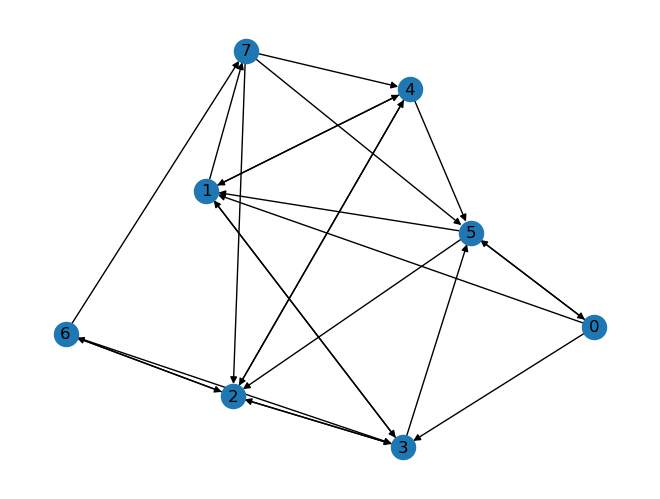

number of actions: 24
Sample trajectory:
tensor([[[5, 2, 1],
         [1, 0, 7],
         [7, 0, 4],
         [4, 2, 2],
         [2, 1, 3]]])
S-O mapping:
tensor([0, 1, 2, 3, 4, 5, 6, 7])
Adjacency Matrix:
tensor([[0., 1., 0., 1., 0., 1., 0., 0.],
        [0., 0., 0., 1., 1., 0., 0., 1.],
        [0., 0., 0., 1., 1., 0., 1., 0.],
        [0., 1., 1., 0., 0., 1., 0., 0.],
        [0., 1., 1., 0., 0., 1., 0., 0.],
        [1., 1., 1., 0., 0., 0., 0., 0.],
        [0., 0., 1., 1., 0., 0., 0., 1.],
        [0., 0., 1., 0., 1., 1., 0., 0.]])
action-to-node:
{0: tensor([[0, 1],
        [1, 3],
        [2, 6],
        [3, 1],
        [4, 2],
        [5, 0],
        [6, 7],
        [7, 4]]), 1: tensor([[0, 3],
        [1, 4],
        [2, 4],
        [3, 2],
        [4, 5],
        [5, 2],
        [6, 3],
        [7, 2]]), 2: tensor([[0, 5],
        [1, 7],
        [2, 3],
        [3, 5],
        [4, 1],
        [5, 1],
        [6, 2],
        [7, 5]])}
node-to-action-matrix:
tensor([[-1,  0, 

In [3]:
adj = env.adj_matrix

# Assuming you have the adjacency matrix stored in the variable "adj"
G = nx.from_numpy_array(adj.numpy().astype(float), create_using = nx.DiGraph)

# Draw the graph using seaborn
# sns.set()
seed = 31 # Consistent graph shape across runs
pos = nx.spring_layout(G, seed=seed)
nx.draw(G, pos = pos, with_labels=True)
# Show the plot
plt.show()

print(f"number of actions: {env.n_actions}")

print("Sample trajectory:")
for trajectory in dataloader:
    print(trajectory)
    break

print("S-O mapping:")
print(env.items)
print("Adjacency Matrix:")
print(adj)
print("action-to-node:")
print(env.action_to_node)
print("node-to-action-matrix:")
print(env.node_to_action_matrix)
print("affordance / node - to action:")
print(env.affordance)

In [4]:
# Our code
from trainer import POCMLTrainer
from model import POCML

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = POCML(n_obs = env.n_items,
                n_states = env.size,
                n_actions = env.n_actions,
                state_dim = state_dim,
                random_feature_dim = random_feature_dim,
                alpha = 1,
                beta = 4,
                decay = 0.9)
    
trainer = POCMLTrainer(model=model, 
                       train_loader = dataloader,
                       lr_Q_o = 1, 
                       lr_V_o = 0.1, 
                       lr_Q_s = 0, 
                       lr_V_s = 0, 
                       lr_all = 0.32, 
                       mem_cleanup_rate = 0.0
                       )

loss_record = np.array(trainer.train(epochs)).reshape(epochs,-1)

Epochs:   0%|          | 0/6 [00:00<?, ?it/s]

Current Trajectory tensor([[4, 1, 1],
        [1, 0, 7],
        [7, 1, 5],
        [5, 2, 1],
        [1, 1, 4]])
initial state: tensor(4)
Print initial score tensor([0.3963, 0.3644, 0.3376, 0.3948, 0.9999, 0.3604, 0.3952, 0.3997])
Obs similarity
 tensor([[1.0000, 0.3726, 0.3881, 0.3866, 0.3963, 0.3754, 0.4181, 0.4095],
        [0.3726, 1.0000, 0.3442, 0.3359, 0.3644, 0.3181, 0.4182, 0.3318],
        [0.3881, 0.3442, 1.0000, 0.3453, 0.3376, 0.3294, 0.3797, 0.3497],
        [0.3866, 0.3359, 0.3453, 1.0000, 0.3948, 0.3572, 0.4152, 0.3810],
        [0.3963, 0.3644, 0.3376, 0.3948, 1.0000, 0.3604, 0.3952, 0.3997],
        [0.3754, 0.3181, 0.3294, 0.3572, 0.3604, 1.0000, 0.3766, 0.3429],
        [0.4181, 0.4182, 0.3797, 0.4152, 0.3952, 0.3766, 1.0000, 0.3841],
        [0.4095, 0.3318, 0.3497, 0.3810, 0.3997, 0.3429, 0.3841, 1.0000]])
Action difference
 tensor([[0.0000, 1.4390, 1.3986, 1.4522, 1.4755, 1.4238, 1.4676, 1.4316, 1.3766,
         1.5349, 1.4419, 1.4278, 1.4636, 1.4134, 1.4263, 1

In [5]:
print(model.Q.T @ model.Q)
print((model.Q.T @ model.Q).shape)

tensor([[4.8929, 4.8929, 4.8929, 4.8929, 4.8929, 4.8929, 4.8929, 4.8929],
        [4.8929, 4.8929, 4.8929, 4.8929, 4.8929, 4.8929, 4.8929, 4.8929],
        [4.8929, 4.8929, 4.8929, 4.8929, 4.8929, 4.8929, 4.8929, 4.8929],
        [4.8929, 4.8929, 4.8929, 4.8929, 4.8929, 4.8929, 4.8929, 4.8929],
        [4.8929, 4.8929, 4.8929, 4.8929, 4.8929, 4.8929, 4.8929, 4.8929],
        [4.8929, 4.8929, 4.8929, 4.8929, 4.8929, 4.8929, 4.8929, 4.8929],
        [4.8929, 4.8929, 4.8929, 4.8929, 4.8929, 4.8929, 4.8929, 4.8929],
        [4.8929, 4.8929, 4.8929, 4.8929, 4.8929, 4.8929, 4.8929, 4.8929]],
       grad_fn=<MmBackward0>)
torch.Size([8, 8])


In [6]:
print(model.V.T @ model.V)

tensor([[ 7.3055e-15,  1.9193e-15,  2.4438e-15,  3.3429e-09, -4.3591e-09,
          3.2507e-09, -3.8626e-09,  1.2719e-09,  5.5634e-10, -9.2484e-09,
         -7.9602e-10, -2.9984e-09,  1.8701e-09, -2.1499e-10,  1.9013e-09,
          4.2313e-09, -9.4702e-10, -4.2691e-09, -1.8897e-09,  1.3831e-09,
         -3.8707e-09, -9.5139e-10, -4.3109e-09,  4.8654e-09],
        [ 1.9193e-15,  7.2590e-15,  1.8624e-15,  1.6473e-09, -1.4400e-09,
          1.5364e-09, -3.1486e-09,  4.2046e-09, -7.0808e-09,  5.3707e-09,
         -4.5519e-09, -2.2485e-09, -4.7094e-10, -3.4828e-09, -2.7405e-09,
          2.2499e-09,  5.0155e-09,  1.2512e-09, -5.1192e-09,  5.7287e-09,
         -2.8511e-09, -4.5519e-09, -4.1092e-10,  5.4927e-09],
        [ 2.4438e-15,  1.8624e-15,  7.1465e-15,  1.0009e-08, -5.9949e-09,
         -7.3462e-10, -4.3466e-09,  5.8480e-09, -1.4155e-09,  3.2377e-09,
         -1.2536e-09, -7.4948e-09, -4.1189e-09,  2.8092e-09, -4.6314e-09,
          3.1545e-09, -1.8490e-10,  6.4086e-10,  4.8060e-09,  

In [7]:
print(model.M.T @ model.M.conj())

tensor([[1.0000+0.j, 1.0000+0.j, 1.0000+0.j, 1.0000+0.j, 1.0000+0.j, 1.0000+0.j, 1.0000+0.j,
         1.0000+0.j],
        [1.0000+0.j, 1.0000+0.j, 1.0000+0.j, 1.0000+0.j, 1.0000+0.j, 1.0000+0.j, 1.0000+0.j,
         1.0000+0.j],
        [1.0000+0.j, 1.0000+0.j, 1.0000+0.j, 1.0000+0.j, 1.0000+0.j, 1.0000+0.j, 1.0000+0.j,
         1.0000+0.j],
        [1.0000+0.j, 1.0000+0.j, 1.0000+0.j, 1.0000+0.j, 1.0000+0.j, 1.0000+0.j, 1.0000+0.j,
         1.0000+0.j],
        [1.0000+0.j, 1.0000+0.j, 1.0000+0.j, 1.0000+0.j, 1.0000+0.j, 1.0000+0.j, 1.0000+0.j,
         1.0000+0.j],
        [1.0000+0.j, 1.0000+0.j, 1.0000+0.j, 1.0000+0.j, 1.0000+0.j, 1.0000+0.j, 1.0000+0.j,
         1.0000+0.j],
        [1.0000+0.j, 1.0000+0.j, 1.0000+0.j, 1.0000+0.j, 1.0000+0.j, 1.0000+0.j, 1.0000+0.j,
         1.0000+0.j],
        [1.0000+0.j, 1.0000+0.j, 1.0000+0.j, 1.0000+0.j, 1.0000+0.j, 1.0000+0.j, 1.0000+0.j,
         1.0000+0.j]])


Text(0.5, 0, 'Epochs')

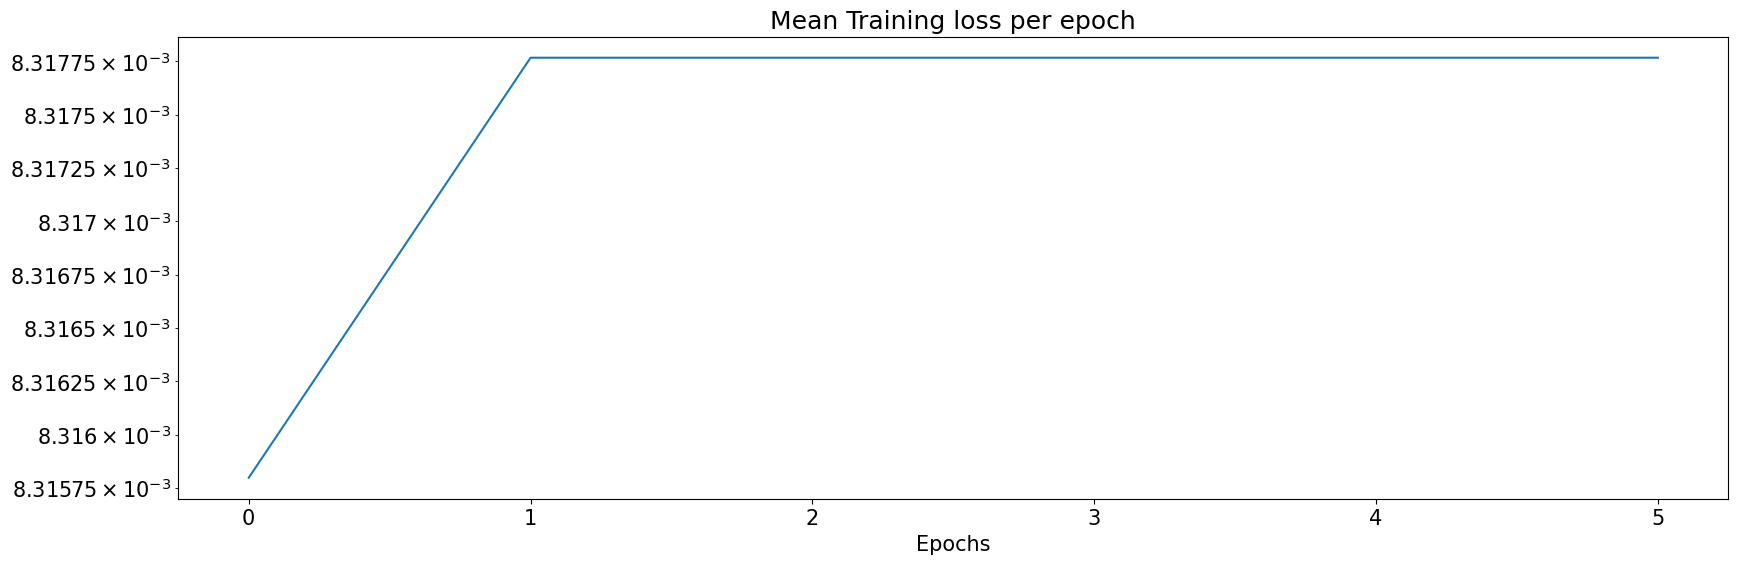

In [8]:
# our trainer loss plot - flattened 

plt.rcParams['font.size'] = 15
plt.figure(figsize=(20, 6))
plt.plot(np.mean(loss_record, axis=1)/(env.num_desired_trajectories * (env.batch_size-1) ))
plt.yscale('log')
plt.title('Mean Training loss per epoch') # mean over the # trajectory and # steps in trajectory 
plt.xlabel('Epochs')

[  0.1   1.   10.  100. ]


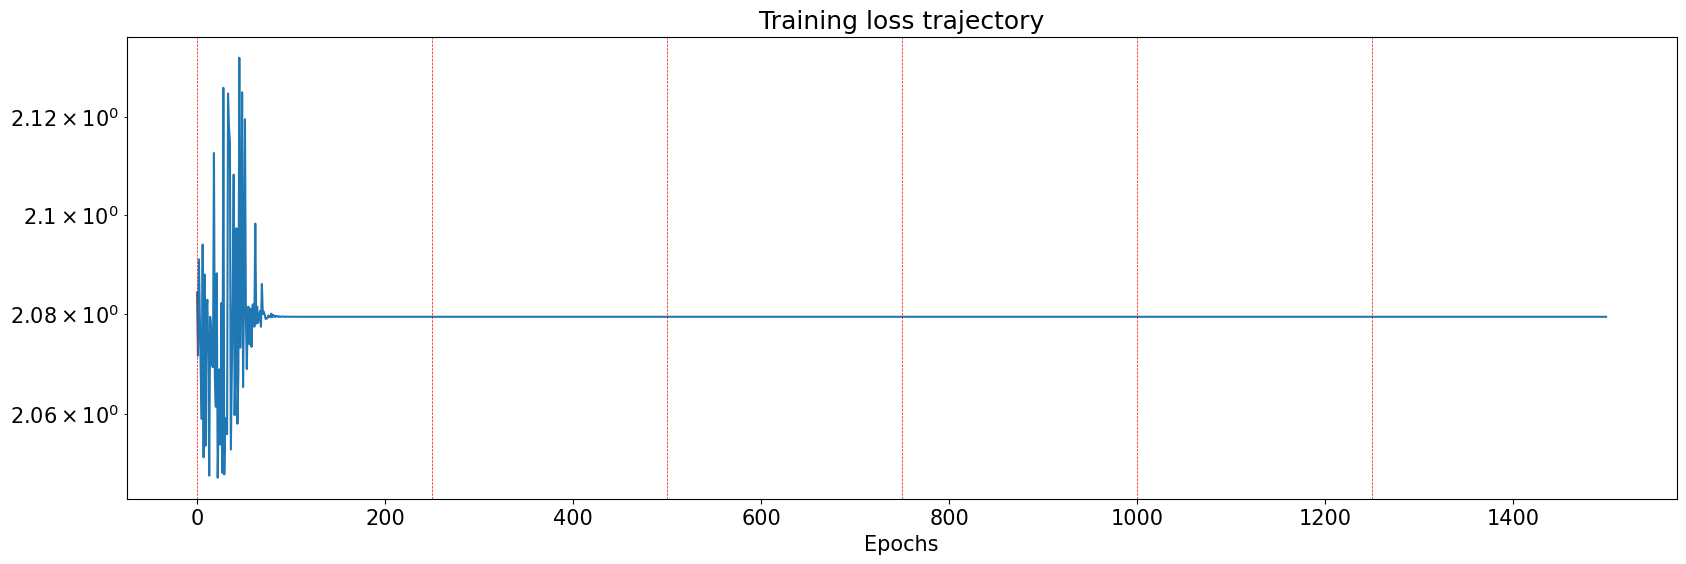

In [9]:
# our trainer loss plot - flattened 

plt.rcParams['font.size'] = 15
plt.figure(figsize=(20, 6))
plt.plot(loss_record.reshape(-1))
plt.yscale('log')
plt.title('Training loss trajectory') # mean over the # trajectory and # steps in trajectory 
plt.xlabel('Epochs')

# Get the current y-ticks
yticks = plt.yticks()[0]

print(yticks)

# Add vertical lines at each multiple of 5

for i in range(0, len(loss_record.reshape(-1)), num_desired_trajectories * (trajectory_length-1)):
    plt.axvline(x=i, color='red', linestyle='--', linewidth=0.5)



In [ ]:

device = torch.device("cpu")

# CML 
def test_model(model, env, print_results=True):
    N_nodes = model.o_size
    dis = []
    D_dis = []
    N_goal = 1000
    adj_matrix_tensor = env.adj_matrix.to(device)
    graph = nx.from_numpy_array(env.adj_matrix.cpu().numpy(), create_using=nx.DiGraph())
    for i in range(N_goal):
        start_idx = torch.randint(N_nodes, (1,)).to(device)[0]
        goal_idx = torch.randint(N_nodes, (1,)).to(device)[0]
        with torch.no_grad():
            steps, o_record = model.plan(start_idx, goal_idx, env, False)
        D_path = nx.shortest_path(graph, source=int(start_idx.cpu()), target=int(goal_idx.cpu()))
        D_steps = len(D_path) - 1
        dis.append(steps)
        D_dis.append(D_steps)

    # Convert lists to tensors and move them to GPU
    dis = torch.tensor(dis).float().to(device)
    D_dis = torch.tensor(D_dis).float().to(device)
    mask = dis != (N_nodes-1)
    mean_CML = torch.mean(dis).item()
    std_CML = torch.std(dis).item()
    mean_Dij = torch.mean(D_dis).item()
    std_Dij = torch.std(D_dis).item()
    if print_results:
        print('CML steps:', str(mean_CML)[:6], ', Success Rate:', str((mask.sum() / N_goal * 100).item())[:6] + '%',
          ', Dij steps:', str(mean_Dij)[:6], ', Percentage worse:', str((mean_CML / mean_Dij - 1) * 100)[:6] + '%')
        print('CML std: ', str(std_CML)[:6], ' Dij std: ', str(std_Dij)[:6])
    else:
        return mean_CML
# 

In [ ]:

device = torch.device("cpu")

# CML 
def test_model(model, env, print_results=True):
    N_nodes = model.o_size
    dis = []
    D_dis = []
    N_goal = 1000
    adj_matrix_tensor = env.adj_matrix.to(device)
    graph = nx.from_numpy_array(env.adj_matrix.cpu().numpy(), create_using=nx.DiGraph())
    for i in range(N_goal):
        start_idx = torch.randint(N_nodes, (1,)).to(device)[0]
        goal_idx = torch.randint(N_nodes, (1,)).to(device)[0]
        with torch.no_grad():
            #steps, o_record = model.plan(start_idx, goal_idx, env, False)
            steps = model.plan(state, affordance=None):

        D_path = nx.shortest_path(graph, source=int(start_idx.cpu()), target=int(goal_idx.cpu()))
        D_steps = len(D_path) - 1
        dis.append(steps)
        D_dis.append(D_steps)

    # Convert lists to tensors and move them to GPU
    dis = torch.tensor(dis).float().to(device)
    D_dis = torch.tensor(D_dis).float().to(device)
    mask = dis != (N_nodes-1)
    mean_CML = torch.mean(dis).item()
    std_CML = torch.std(dis).item()
    mean_Dij = torch.mean(D_dis).item()
    std_Dij = torch.std(D_dis).item()
    if print_results:
        print('CML steps:', str(mean_CML)[:6], ', Success Rate:', str((mask.sum() / N_goal * 100).item())[:6] + '%',
          ', Dij steps:', str(mean_Dij)[:6], ', Percentage worse:', str((mean_CML / mean_Dij - 1) * 100)[:6] + '%')
        print('CML std: ', str(std_CML)[:6], ' Dij std: ', str(std_Dij)[:6])
    else:
        return mean_CML
# 

In [ ]:
# CML's model

def test_model(model, env, print_results=True):
    N_nodes = model.o_size
    dis = []
    D_dis = []
    N_goal = 1000
    adj_matrix_tensor = env.adj_matrix.to(device)
    graph = nx.from_numpy_matrix(env.adj_matrix.cpu().numpy(), create_using=nx.DiGraph())
    for i in range(N_goal):
        start_idx = torch.randint(N_nodes, (1,)).to(device)[0]
        goal_idx = torch.randint(N_nodes, (1,)).to(device)[0]
        with torch.no_grad():
            steps, o_record = model.plan(start_idx, goal_idx, env, False)
        D_path = nx.shortest_path(graph, source=int(start_idx.cpu()), target=int(goal_idx.cpu()))
        D_steps = len(D_path) - 1
        dis.append(steps)
        D_dis.append(D_steps)

    # Convert lists to tensors and move them to GPU
    dis = torch.tensor(dis).float().to(device)
    D_dis = torch.tensor(D_dis).float().to(device)
    mask = dis != (N_nodes-1)
    mean_CML = torch.mean(dis).item()
    std_CML = torch.std(dis).item()
    mean_Dij = torch.mean(D_dis).item()
    std_Dij = torch.std(D_dis).item()
    if print_results:
        print('CML steps:', str(mean_CML)[:6], ', Success Rate:', str((mask.sum() / N_goal * 100).item())[:6] + '%',
          ', Dij steps:', str(mean_Dij)[:6], ', Percentage worse:', str((mean_CML / mean_Dij - 1) * 100)[:6] + '%')
        print('CML std: ', str(std_CML)[:6], ' Dij std: ', str(std_Dij)[:6])
    else:
        return mean_CML
# 